In [1]:
import tensorflow as tf
%matplotlib notebook
%matplotlib inline
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import cv2
import datetime
import random
from tensorflow.keras.layers import Dense, GRU, TimeDistributed, InputLayer

from IPython import display

import seaborn as sns
from tqdm.notebook import tqdm, trange
sns.set()
tf.keras.backend.floatx()

'float32'

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

# Create recurrent dataset with multiple modes

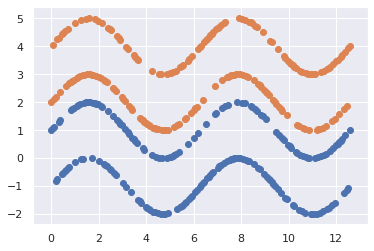

In [3]:
dataset_size = 100
x = np.linspace(0, np.pi * 4, 200)
y1 = np.sin(x) + 1
y2 = np.sin(x) - 1
y3 = np.sin(x) + 4
y4 = np.sin(x) + 2
mask1 = np.random.randint(0, high=2, size=[dataset_size, x.shape[-1]])
mask2 = np.random.randint(0, high=2, size=[dataset_size, x.shape[-1]])
y1 = y1 * mask1 + y2 * (1 - mask1)
y2 = y3 * mask2 + y4 * (1 - mask2)
y = np.concatenate([y1[:, :, np.newaxis], y2[:, :, np.newaxis]], axis=-1)
plt.scatter(x, y[5, :, 0])
plt.scatter(x, y[5, :, 1])

dots = y.astype(np.float32)

In [7]:
model = tf.keras.Sequential(layers=[
    InputLayer(input_shape=(None, y.shape[-1]), dtype=tf.float32),
    GRU(64, return_sequences=True),
    Dense(64, activation='relu'),
    Dense(y.shape[-1]),
])
model.compile(optimizer='adam', loss='mse')

In [8]:
y = dots[:, 1:]
x = dots[:, :-1]

In [10]:
model.fit(x=x, y=y, batch_size=1, epochs=5)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 2s 15ms/sample - loss: 1.0293
Epoch 2/5
100/100 [==============================] - 2s 15ms/sample - loss: 1.0240
Epoch 3/5
100/100 [==============================] - 2s 15ms/sample - loss: 1.0228
Epoch 4/5
100/100 [==============================] - 2s 15ms/sample - loss: 1.0209
Epoch 5/5
100/100 [==============================] - 2s 15ms/sample - loss: 1.0199


In [11]:
pred = np.zeros_like(y)
for i in range(pred.shape[1]):
    pred[:, i] = model(x[:, :1 + i])[:, -1]

## It predicts the mean of sines!

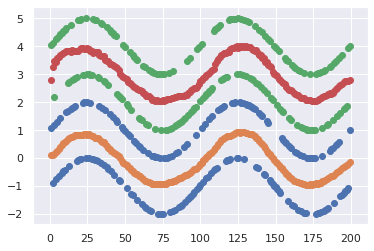

In [18]:
plt.scatter(np.arange(len(x[0])) + 1, y[0, :, 0])
plt.scatter(np.arange(len(x[0])) + 1, pred[0, :, 0])

plt.scatter(np.arange(len(x[0])) + 1, y[0, :, 1])
plt.scatter(np.arange(len(x[0])) + 1, pred[0, :, 1])

# MDN-RNN train

In [34]:
class MDN_RNN(tf.keras.Model):
    def __init__(self, n_mixtures, out_dims):
        super(MDN_RNN, self).__init__()
        
        self.n_mixtures = n_mixtures
        self.out_dims = out_dims
        self.fc1 = Dense(128, activation='tanh', input_shape=(None, 1), dtype=tf.float32)
        self.gru = GRU(64, return_sequences=True)
        self.fc2 = Dense(3 * n_mixtures * out_dims)

    def predict_distribution(self, x):
        ''' 
            x.shape = [batch_size, seq_length, latent_dim]
        '''
        x = self.fc1(x)
        x = self.gru(x)
        x = self.fc2(x)

        mean, log_std, alpha = tf.split(x, 3, axis=2)
        mean = tf.reshape(mean, [-1, self.n_mixtures])
        log_std = tf.reshape(log_std, [-1, self.n_mixtures])
        alpha = tf.reshape(alpha, [-1, self.n_mixtures])
        alpha = tf.nn.softmax(alpha, axis=1)

        return mean, log_std, alpha
    
    def sample(self, x, temperature=1.0, verbose=False):
        # Predicting distribution
        mean, log_std, alpha = self.predict_distribution(x)
        std = tf.exp(log_std) * np.sqrt(temperature)
#         print(alpha)
#         alpha = alpha / temperature
#         alpha -= tf.reduce_max(alpha)
#         alpha = tf.nn.softmax(alpha, axis=-1)
#         print(alpha)
        
        seq_length = x.shape[1]
        
        # Picking component
        rnd = tf.random.uniform(shape=[x.shape[0] * self.out_dims * seq_length, 1], maxval=1)
        rnd = tf.repeat(rnd, self.n_mixtures, axis=-1)
        pdf = tf.cumsum(alpha, axis=-1)
        component_idx = np.argmax(pdf > rnd, axis=-1)
        
        # Gathering std and mean
        idx_flattened = tf.range(0, mean.shape[0]) * mean.shape[1] + component_idx
        component_std = tf.gather(tf.reshape(std, [-1]), idx_flattened)
        component_mean = tf.gather(tf.reshape(mean, [-1]), idx_flattened)

        # Sampling
        samples = tf.random.normal(shape=[x.shape[0] * self.out_dims * seq_length])
        samples = samples * component_std + component_mean
        samples = tf.reshape(samples, [-1, seq_length, self.out_dims])
        
        return samples
    
    def call(self, x):
        return self.sample(x)

In [60]:
def gaussian_pdf(x, mu, sigmasq):
    return (1 / tf.sqrt(2 * np.pi * sigmasq)) * tf.exp((-1 / (2 * sigmasq)) * (x - mu) ** 2)

def loss_fn(model, x, y_true):
    mean, log_std, alpha = model.predict_distribution(x)
    std = tf.exp(log_std) + 0.00001
    y_true = tf.reshape(y_true, [-1])

    prob_sum = 0
    for i in range(model.n_mixtures):
        prob = gaussian_pdf(y_true, mean[:, i], std[:, i])
        prob_sum += prob * alpha[:, i]

    log_prob_sum = tf.reduce_mean(-tf.math.log(prob_sum + 0.00001))
    return log_prob_sum

In [61]:
def train(model):
#     @tf.function
    def gradient_step(model, x, y_true, optimizer):
        with tf.GradientTape() as tape:
            loss = loss_fn(model, x, y_true)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

#     @tf.function
    def fit(model, x, y, optimizer):
        x, y = tf.identity(x), tf.identity(y)
        idx = tf.random.shuffle(tf.range(len(x)))
        x = tf.gather(x, idx)
        y = tf.gather(y, idx)
        for j in range(len(x) // batch_size):
            loss = gradient_step(model, 
                                 x[j * batch_size: (j + 1) * batch_size], 
                                 y[j * batch_size: (j + 1) * batch_size], 
                                 optimizer)
        return loss
    
    batch_size = 32
    optimizer = tf.keras.optimizers.Adam(1e-3)
    t = trange(300)
    for i in t:
        loss = fit(model, x, y, optimizer)
        t.set_description('%.2f' % loss.numpy())

In [71]:
n_mixtures = 3
model = MDN_RNN(n_mixtures=n_mixtures, out_dims=y.shape[-1])
train(model)

In [72]:
model.predict_distribution(x[:, :1 + i])[0]

<tf.Tensor: shape=(39800, 3), dtype=float32, numpy=
array([[-0.12032807, -0.7914528 ,  1.2651262 ],
       [ 2.050306  ,  3.9766142 ,  3.2603788 ],
       [-0.07159737, -0.68939066,  1.402966  ],
       ...,
       [ 1.9784781 ,  3.9653718 ,  3.1435924 ],
       [-0.6997973 , -0.9753797 ,  1.0440001 ],
       [ 2.0398157 ,  4.0239716 ,  3.1540046 ]], dtype=float32)>

In [73]:
pred_samples = np.zeros_like(y)
for i in range(y.shape[1]):
    pred_samples[:, i] = model.sample(x[:, :1 + i])[:, -1]
    
mean1 = np.zeros_like(y)
mean2 = np.zeros_like(y)
mean3 = np.zeros_like(y)
mean4 = np.zeros_like(y)
for i in range(y.shape[1]):
    pred = model.predict_distribution(x[:, :1 + i])[0]
    mean1[:, i] = pred.numpy().reshape((len(x), -1, y.shape[-1], n_mixtures))[:, -1, 0, 0][:,np.newaxis]
    mean2[:, i] = pred.numpy().reshape((len(x), -1, y.shape[-1], n_mixtures))[:, -1, 0, 1][:,np.newaxis]
    mean3[:, i] = pred.numpy().reshape((len(x), -1, y.shape[-1], n_mixtures))[:, -1, 1, 0][:,np.newaxis]
    mean4[:, i] = pred.numpy().reshape((len(x), -1, y.shape[-1], n_mixtures))[:, -1, 1, 1][:,np.newaxis]


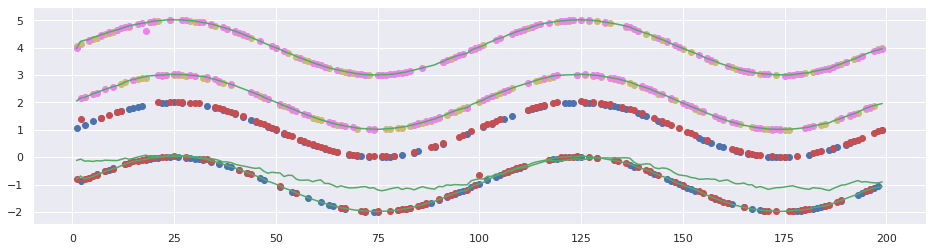

In [74]:
plt.figure(figsize=(16, 4))
plt.scatter(np.arange(len(x[0])) + 1, y[0, :, 0], c='b')
plt.scatter(np.arange(len(x[0])) + 1, y[0, :, 1], c='y')
plt.scatter(np.arange(len(x[0])) + 1, pred_samples[0, :, 0], c='r')
plt.scatter(np.arange(len(x[0])) + 1, pred_samples[0, :, 1], c='violet')
plt.plot(np.arange(len(x[0])) + 1, mean1[0, :, 0], c='g')
plt.plot(np.arange(len(x[0])) + 1, mean2[0, :, 0], c='g')
plt.plot(np.arange(len(x[0])) + 1, mean3[0, :, 0], c='g')
plt.plot(np.arange(len(x[0])) + 1, mean4[0, :, 0], c='g')